<a href="https://colab.research.google.com/github/lalooms/SC1015_Mini_Project/blob/main/SC1015_Bike_Sharing_Demand.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Can we predict total bike rentals using {insert predictor} and how accurate is it? 

1. Libraries and Data Loading

A. Used Libraries

In [ ]:
# Basic Libraries
import calendar
import numpy as np
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt # we only need pyplot
sb.set() # set the default Seaborn style for graphics

#regression
from sklearn.linear_model import LinearRegression,Ridge,Lasso,RidgeCV
from sklearn.ensemble import RandomForestRegressor,BaggingRegressor,GradientBoostingRegressor,AdaBoostRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor

#model selection
from sklearn.model_selection import train_test_split,cross_validate
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV

#evaluation metrics
from sklearn.metrics import mean_squared_log_error,mean_squared_error, r2_score,mean_absolute_error 

# Ignore  the warnings
import warnings
warnings.filterwarnings('always')
warnings.filterwarnings('ignore')

import scipy.stats as stats


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


###Description of features.
datetime - hourly date + timestamp

season - 

> 1: spring

> 2: summer

> 3: fall

> 4: winter

holiday - whether the day is considered a holiday

workingday - whether the day is neither a weekend nor holiday

weather -

> 1: Clear, Few clouds, Partly cloudy, Partly cloudy

> 2: Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist

> 3: Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds

> 4: Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog

temp - temperature in Celsius

atemp - "feels like" temperature in Celsius

humidity - relative humidity

windspeed - wind speed

casual - number of non-registered user rentals initiated

registered - number of registered user rentals initiated

count - number of total rentals

B. Load Database

In [ ]:
df = pd.read_csv('/content/train.csv', header = None)
df.head()

,0,1,2,3,4,5,6,7,8,9,10,11
0,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
1,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0,3,13,16
2,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0,8,32,40
3,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0,5,27,32
4,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0,3,10,13


2. Cleaning of Database

In [ ]:
# Check the data types of each column to ensure they are consistent with the data they contain
df.info()
print()
print("The shape of the dataset is:", df.shape)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10887 entries, 0 to 10886
Data columns (total 12 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   0       10887 non-null  object
 1   1       10887 non-null  object
 2   2       10887 non-null  object
 3   3       10887 non-null  object
 4   4       10887 non-null  object
 5   5       10887 non-null  object
 6   6       10887 non-null  object
 7   7       10887 non-null  object
 8   8       10887 non-null  object
 9   9       10887 non-null  object
 10  10      10887 non-null  object
 11  11      10887 non-null  object
dtypes: object(12)
memory usage: 1020.8+ KB

The shape of the dataset is: (10887, 12)


In [ ]:
# assume your dataframe has integer column names
df.columns = df.iloc[0] # set column names to values in the first row
df = df.drop(df.index[0]) # drop the first row since it is now the column names

# check for null valiues
print(df.isnull().sum())
print(' ')

# convert datetime to datetime data type
df['datetime'] = pd.to_datetime(df['datetime'])

# convert variable data types from object to a more suitable data type (Eg: Those with decimal convert to float64)
df['temp'] = pd.to_numeric(df['temp'])
df['atemp'] = pd.to_numeric(df['atemp'])
df['windspeed'] = pd.to_numeric(df['windspeed'])

# convert the following varibales to int64
df['humidity'] = df['humidity'].astype(np.int64)
df['casual'] = df['casual'].astype(np.int64)
df['registered'] = df['registered'].astype(np.int64)
df['count'] = df['count'].astype(np.int64)

# convert the following varibales to int64
df['humidity'] = df['humidity'].astype(np.int64)
df['casual'] = df['casual'].astype(np.int64)
df['registered'] = df['registered'].astype(np.int64)
df['count'] = df['count'].astype(np.int64)

# convert the following variables to numeric
# for calculating correlation to target var
df['season'] = pd.to_numeric(df['season'])
df['holiday'] = pd.to_numeric(df['holiday'])
df['workingday'] = pd.to_numeric(df['workingday'])
df['weather'] = pd.to_numeric(df['weather'])

#remove irrelevant variables
# df = df.drop(['casual', 'registered'], axis=1)

#check for duplicates
df.drop_duplicates(inplace=True)

#remove outliers
def remove_outliers(df, col):
    q1 = df[col].quantile(0.25)
    q3 = df[col].quantile(0.75)
    iqr = q3 - q1
    upper = q3 + 1.5 * iqr
    lower = q1 - 1.5 * iqr
    df = df[(df[col] >= lower) & (df[col] <= upper)]
    return df

df = remove_outliers(df, 'count')
#df = remove_outliers(df, 'temp')
#df = remove_outliers(df, 'atemp')
#df = remove_outliers(df, 'humidity')
#df = remove_outliers(df, 'windspeed')

#encode the categorical variables
#df = pd.get_dummies(df, columns=['season', 'weather'])

# #creating new column "date" and "DayOfWeek" to organise days in a week
# df["date"] = df.datetime.apply(lambda x : x.split()[0])
# df["weekday"] = df.date.apply(lambda dateString :calendar.day_name[datetime.strptime(dateString,"%Y-%m-%d").weekday()])

#split the datetime variable
df['datetime'] = pd.to_datetime(df['datetime'])
df['year'] = df['datetime'].dt.year
df['month'] = df['datetime'].dt.month
df['day'] = df['datetime'].dt.day
df['hour'] = df['datetime'].dt.hour
df = df.drop('datetime', axis=1)

# convert time into categorical data
df['year'] = df['year'].astype('category')
df['month'] = df['month'].astype('category')
df['day'] = df['day'].astype('category')
df['hour'] = df['hour'].astype('category')

df.info()
print()
print("The shape of the dataset is:", df.shape)
print()
df.head()

0
datetime      0
season        0
holiday       0
workingday    0
weather       0
temp          0
atemp         0
humidity      0
windspeed     0
casual        0
registered    0
count         0
dtype: int64
 
<class 'pandas.core.frame.DataFrame'>
Int64Index: 10586 entries, 1 to 10886
Data columns (total 15 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   season      10586 non-null  int64   
 1   holiday     10586 non-null  int64   
 2   workingday  10586 non-null  int64   
 3   weather     10586 non-null  int64   
 4   temp        10586 non-null  float64 
 5   atemp       10586 non-null  float64 
 6   humidity    10586 non-null  int64   
 7   windspeed   10586 non-null  float64 
 8   casual      10586 non-null  int64   
 9   registered  10586 non-null  int64   
 10  count       10586 non-null  int64   
 11  year        10586 non-null  category
 12  month       10586 non-null  category
 13  day         10586 non-null  category
 14  hour 

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,year,month,day,hour
1,1,0,0,1,9.84,14.395,81,0.0,3,13,16,2011,1,1,0
2,1,0,0,1,9.02,13.635,80,0.0,8,32,40,2011,1,1,1
3,1,0,0,1,9.02,13.635,80,0.0,5,27,32,2011,1,1,2
4,1,0,0,1,9.84,14.395,75,0.0,3,10,13,2011,1,1,3
5,1,0,0,1,9.84,14.395,75,0.0,0,1,1,2011,1,1,4


Database Summary

0            season       holiday    workingday       weather          temp  \
count  10586.000000  10586.000000  10586.000000  10586.000000  10586.000000   
mean       2.498489      0.029189      0.676459      1.422539     20.061494   
std        1.121629      0.168345      0.467849      0.636549      7.781496   
min        1.000000      0.000000      0.000000      1.000000      0.820000   
25%        1.000000      0.000000      0.000000      1.000000     13.940000   
50%        2.000000      0.000000      1.000000      1.000000     20.500000   
75%        4.000000      0.000000      1.000000      2.000000     26.240000   
max        4.000000      1.000000      1.000000      4.000000     41.000000   

0             atemp      humidity     windspeed        casual    registered  \
count  10586.000000  10586.000000  10586.000000  10586.000000  10586.000000   
mean      23.476271     62.165124     12.776699     33.973172    141.743907   
std        8.467852     19.231315      8.173430    

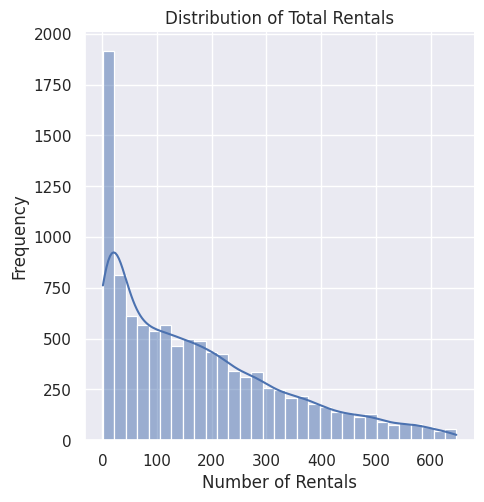

In [ ]:
# Generate summary statistics for numeric columns
print(df.describe())
print()

# Print correlation matrix
print(df.corr())

sb.displot(df['count'], kde=True)
plt.title('Distribution of Total Rentals')
plt.xlabel('Number of Rentals')
plt.ylabel('Frequency')
plt.show()


histogram of count shows that the distribution is positively skewed, meaning that there are more rentals on the lower end of the scale and fewer rentals on the higher end. This suggests that there may be outliers or a long tail to the right in the distribution of the count variable, which may need to be addressed during data preprocessing or modeling.



3. Descriptive Analysis

A. Data Visualisation

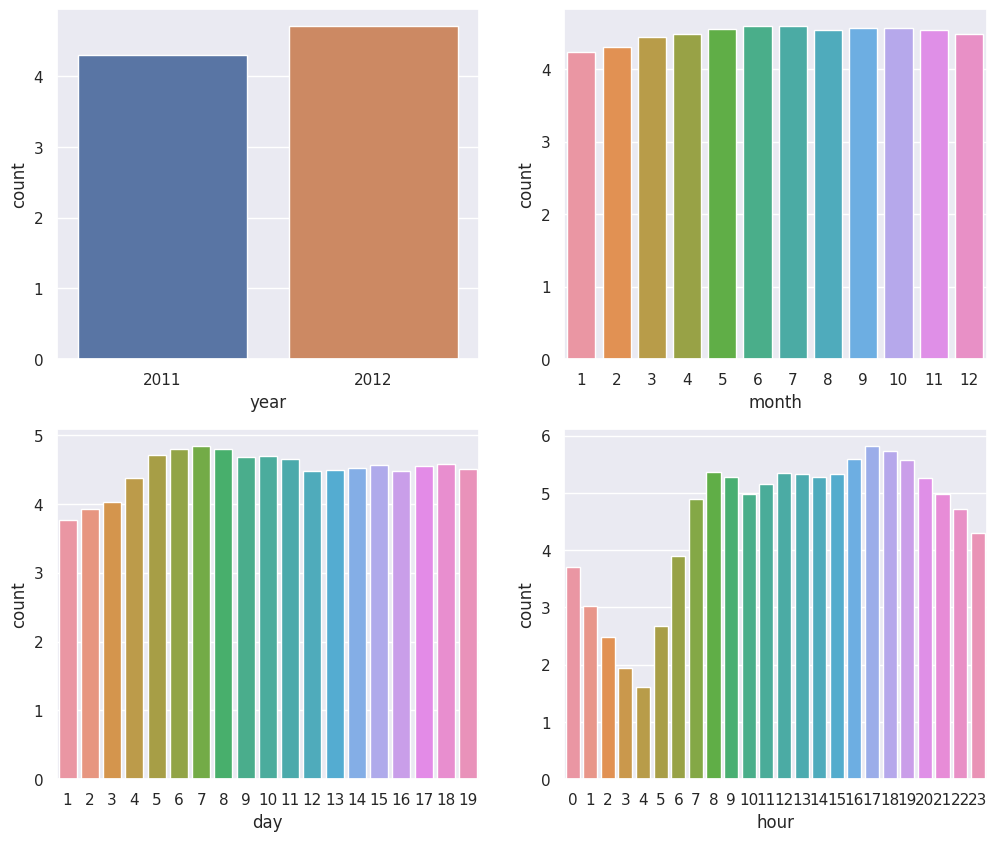

In [ ]:
# visualising categorical predictor variables with response (count)

# year and count
fig = plt.figure(figsize=[12,10])
ax1 = fig.add_subplot(2,2,1)
ax1 = sb.barplot(x='year',y='count',data=df.groupby('year')['count'].mean().reset_index())

# month and count
ax2 = fig.add_subplot(2,2,2)
ax2 = sb.barplot(x='month',y='count',data=df.groupby('month')['count'].mean().reset_index())

# day and count
ax3 = fig.add_subplot(2,2,3)
ax3 = sb.barplot(x='day',y='count',data=df.groupby('day')['count'].mean().reset_index())

# hour and count
ax4 = fig.add_subplot(2,2,4)
ax4 = sb.barplot(x='hour',y='count',data=df.groupby('hour')['count'].mean().reset_index())

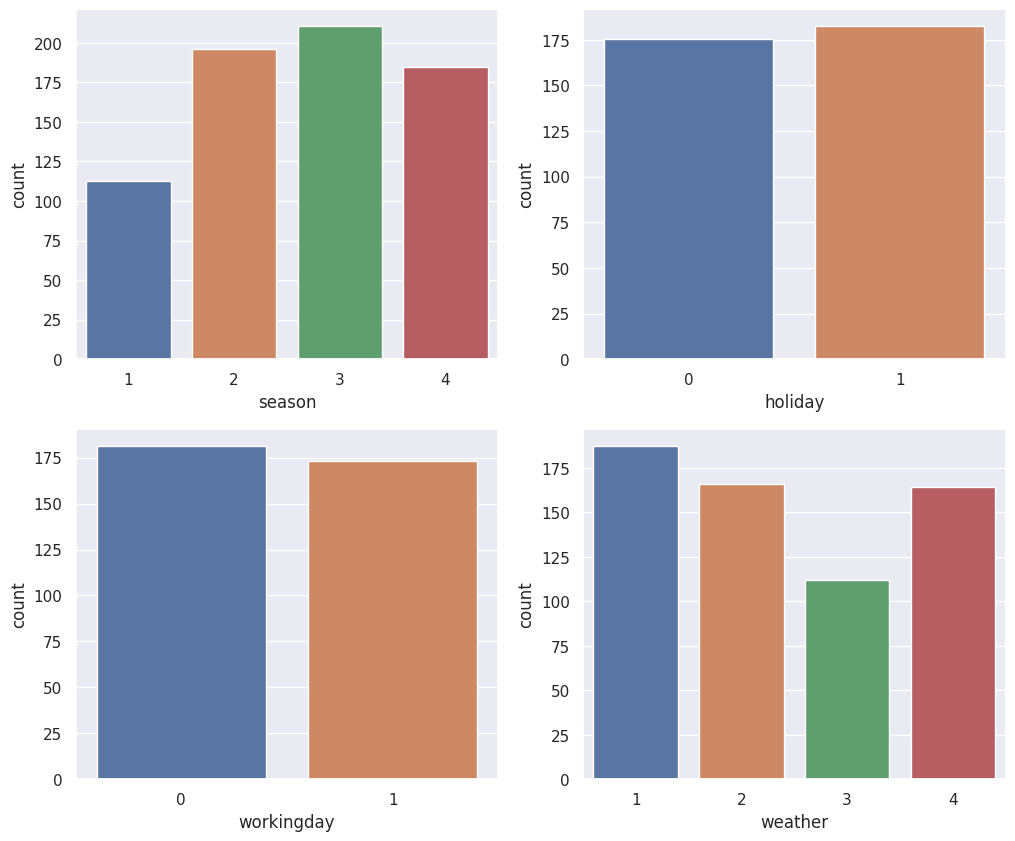

In [ ]:

# season and count
fig = plt.figure(figsize=[12,10])
ax1 = fig.add_subplot(2,2,1)
ax1 = sb.barplot(x='season',y='count',data=df.groupby('season')['count'].mean().reset_index())

# holiday and count
ax2 = fig.add_subplot(2,2,2)
ax2 = sb.barplot(x='holiday',y='count',data=df.groupby('holiday')['count'].mean().reset_index())

# workingday and count
ax3 = fig.add_subplot(2,2,3)
ax3 = sb.barplot(x='workingday',y='count',data=df.groupby('workingday')['count'].mean().reset_index())

# weather and count
ax4 = fig.add_subplot(2,2,4)
ax4 = sb.barplot(x='weather',y='count',data=df.groupby('weather')['count'].mean().reset_index())

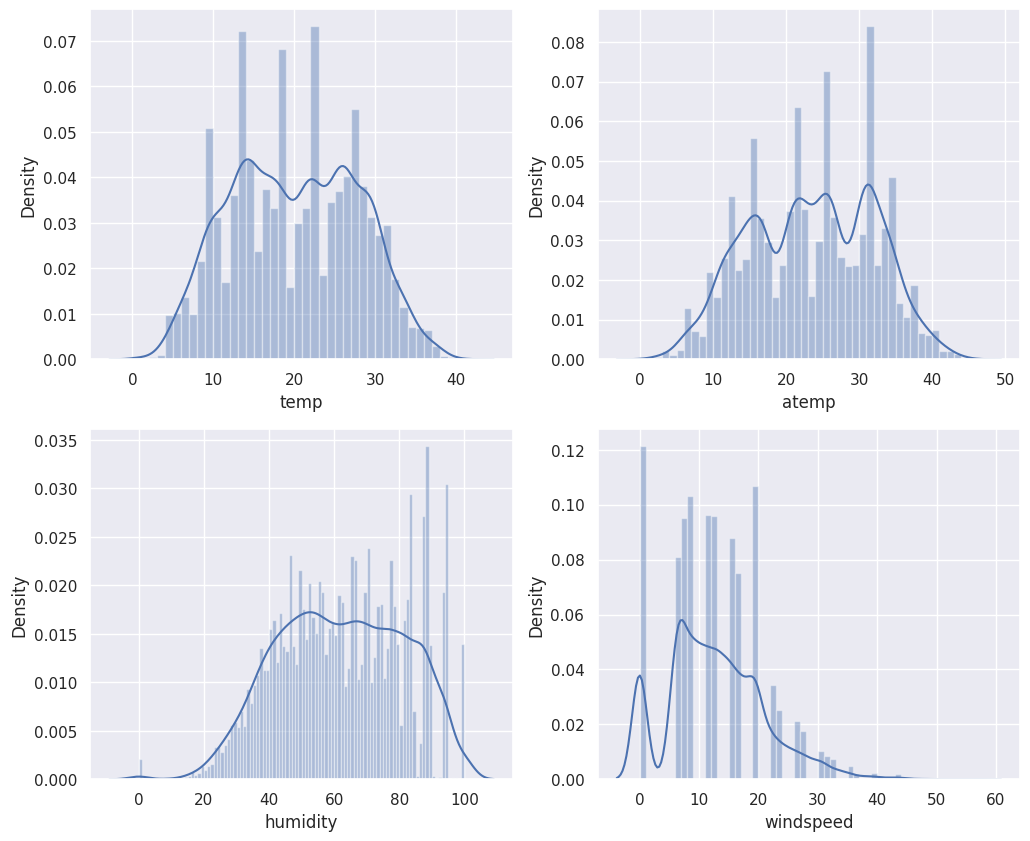

In [ ]:
# visualising numerical predictor variables

# temp distribution
fig = plt.figure(figsize=[12,10])
ax1 = fig.add_subplot(2,2,1)
ax1 = sb.distplot(df.temp,bins=range(df.temp.min().astype('int'),df.temp.max().astype('int')+1))

# atemp distribution
ax2 = fig.add_subplot(2,2,2)
ax2 = sb.distplot(df.atemp,bins=range(df.atemp.min().astype('int'),df.atemp.max().astype('int')+1))

# humiidity distribution
ax3 = fig.add_subplot(2,2,3)
ax3 = sb.distplot(df.humidity,bins=range(df.humidity.min().astype('int'),df.humidity.max().astype('int')+1))

# windspeed distribution
ax4 = fig.add_subplot(2,2,4)
ax4 = sb.distplot(df.windspeed,bins=range(df.windspeed.min().astype('int'),df.windspeed.max().astype('int')+1))

B. Analysis on numerical variables

<Axes: xlabel='0', ylabel='0'>

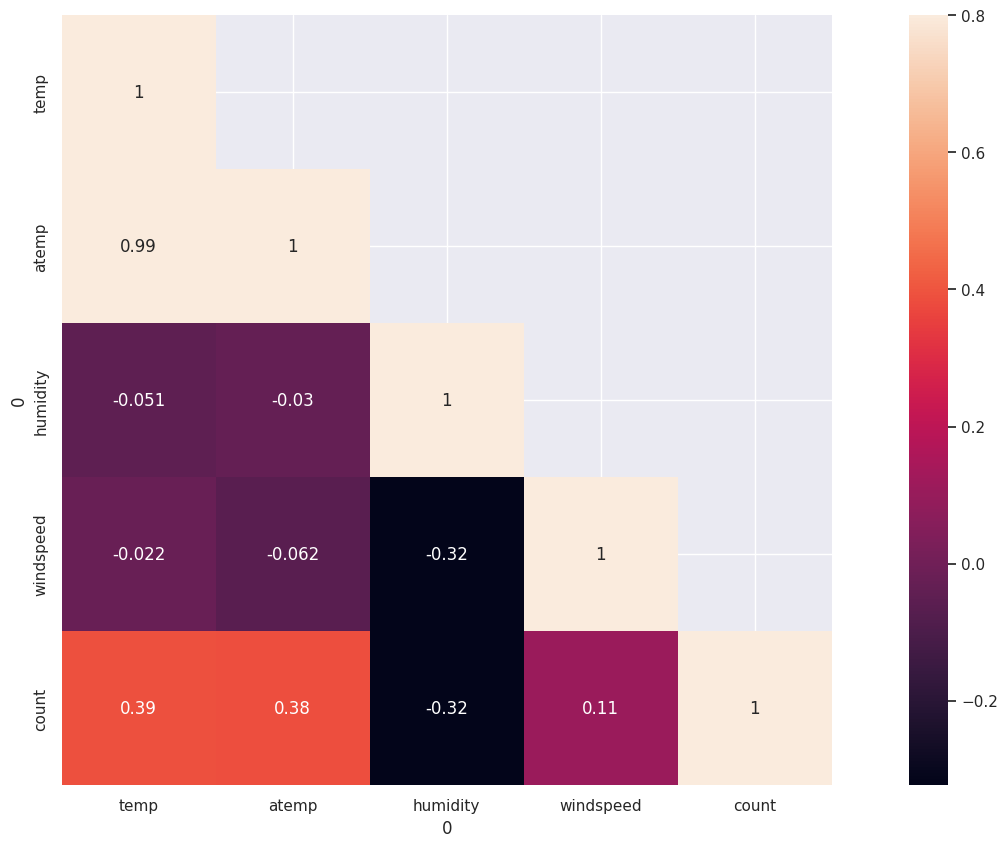

In [ ]:
corrMatt = df[["temp","atemp","humidity","windspeed","count"]].corr()
mask = np.array(corrMatt)
mask[np.tril_indices_from(mask)] = False
fig,ax= plt.subplots()
fig.set_size_inches(20,10)
sb.heatmap(corrMatt, mask=mask,vmax=.8, square=True,annot=True)

temp and humidity has positive and negative correlation with count respectively. Although the correlation between them are not very prominent, count still has some dependency on them.

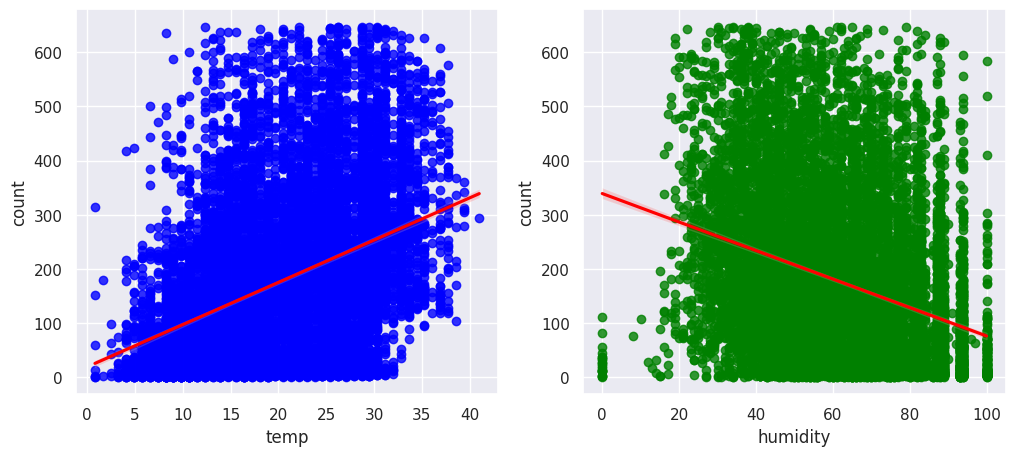

In [ ]:
fig,(ax1,ax2) = plt.subplots(ncols=2)
fig.set_size_inches(12, 5)

# plot temp vs count in blue
sb.regplot(x="temp", y="count", data=df,ax=ax1, color="blue",line_kws={"color":"red"})

# plot humidity vs count in green
sb.regplot(x="humidity", y="count", data=df,ax=ax2, color="green",line_kws={"color":"red"})

plt.show()


From the scatterplot, it looks like temp has a slight correlation with count. Maybe we can give it a shot at predicting count later on. Also we can drop atemp since it is highly related to temp, adding it might cause overfitting

C. Analysis on Categorical variables

In [ ]:

# Define the categorical variables
cat_vars = ['season', 'holiday', 'workingday', 'weather', 'year', 'month', 'day', 'hour']

# Create an empty DataFrame to store the results
results_df = pd.DataFrame(columns=['Variable', 'Correlation', 'P-value'])

# Loop through each categorical variable and compute the correlation
for var in cat_vars:
    if len(df[var].unique()) == 2:
        # For binary variables, compute PBCC
        pbcc, p_value = stats.pointbiserialr(df[var], df['count'])
        results_df = pd.concat([results_df, pd.DataFrame({'Variable': [var], 'Correlation': [pbcc], 'P-value': [p_value]})], ignore_index=True)
    else:
        # For variables with more than two categories, compute Phi Coefficient
        cont_table = pd.crosstab(df[var], df['count'])
        phi_coef, p_value, dof, expected = stats.chi2_contingency(cont_table, correction=False)
        results_df = pd.concat([results_df, pd.DataFrame({'Variable': [var], 'Correlation': [phi_coef], 'P-value': [p_value]})], ignore_index=True)

# Print the results
print(results_df)

     Variable   Correlation        P-value
0      season   2964.599153   8.752985e-48
1     holiday      0.007621   4.330150e-01
2  workingday     -0.025021   1.004078e-02
3     weather   1720.455613   9.996342e-01
4        year      0.206398  3.311578e-102
5       month   8385.982619   1.379925e-26
6         day  11497.051305   6.046849e-01
7        hour  28580.237683   0.000000e+00


In the case of the given dataset, some variables have only two categories (binary variables) and some have more than two categories. For binary variables, the Point Biserial Correlation Coefficient (PBCC) is an appropriate measure of correlation, whereas for variables with more than two categories, the Phi Coefficient is used.

In the given code, the variables 'holiday' and 'workingday' have only two categories and hence PBCC is used to measure their correlation with the target variable 'count'. On the other hand, 'season' and 'weather' have more than two categories, and hence Phi Coefficient is used to measure their correlation with the target variable 'count'. This is why we use both PBCC and Phi Coefficient in the code.

A p-value of 0.9999 indicates that there is almost certainly no significant relationship between the weather and count. It suggests that any observed correlation is likely due to chance and is not statistically significant.

On the other hand, season has an extremely low p-value and a high Phi coefficient. Therefore we can take season as a strongly correlated variable to count.

Of all the time variables, month and hour are similar to season, with higher Phi coeff and low p-value. We should take month and hour to be a significant variable

In [ ]:
df["season"] = df.season.map({1: "Spring", 2 : "Summer", 3 : "Fall", 4 :"Winter" })
df["weather"] = df.weather.map({1: " Clear + Few clouds + Partly cloudy + Partly cloudy",\
                                        2 : " Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist ", \
                                        3 : " Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds", \
                                        4 :" Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog " })

# convert time into categorical data
categoryVariableList = ["hour","day","month","year","season","weather","holiday","workingday"]
for var in categoryVariableList:
    df[var] = df[var].astype("category")


After doing phi test, we map categorical variables to their respective string

D. Visualize variation between correlated variables (temp, season, month and hour) and count


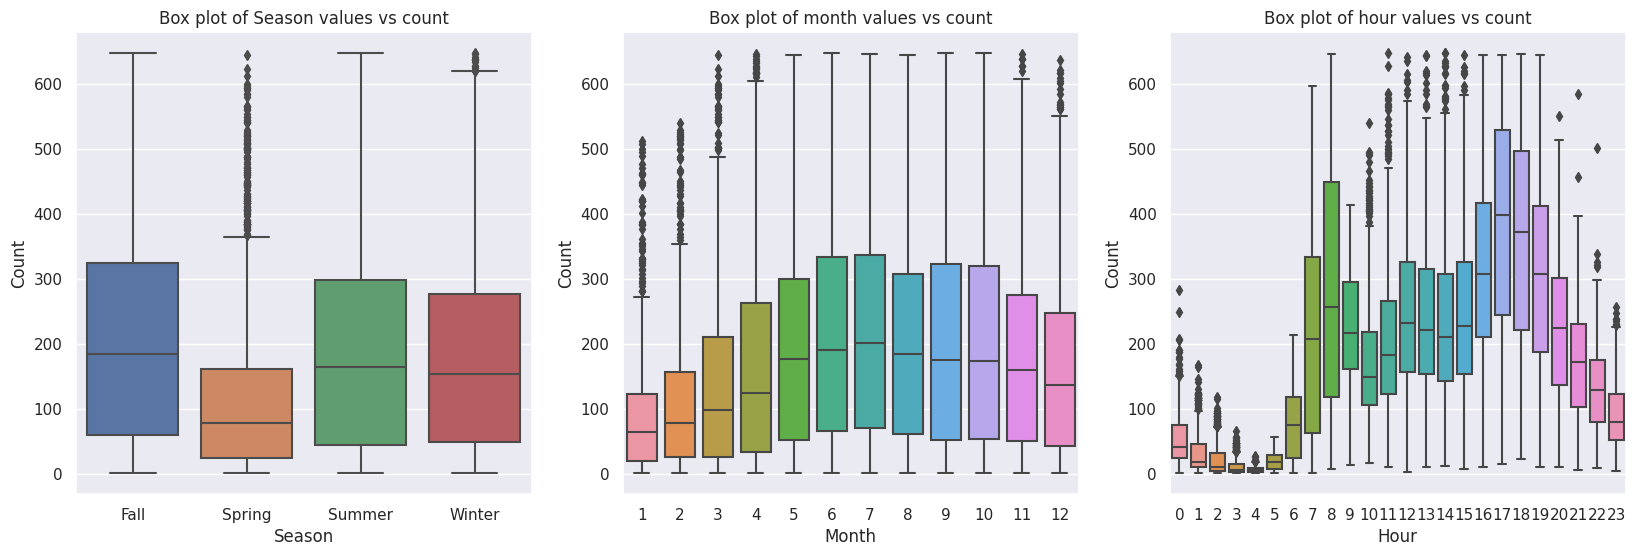

In [ ]:
# Create a 1x2 grid of subplots
fig, axes = plt.subplots(ncols=3, figsize=(20, 6))

# Create box plot for season variable
sb.boxplot(x="season", y="count", data=df, ax=axes[0])
axes[0].set_title("Box plot of Season values vs count")
axes[0].set_xlabel("Season")
axes[0].set_ylabel("Count")

# Create box plot for month variable
sb.boxplot(x="month", y="count", data=df, ax=axes[1])
axes[1].set_title("Box plot of month values vs count")
axes[1].set_xlabel("Month")
axes[1].set_ylabel("Count")
axes[1].set_xticklabels(range(1,13))

# Create box plot for hour variable
sb.boxplot(x="hour", y="count", data=df, ax=axes[2])
axes[2].set_title("Box plot of hour values vs count")
axes[2].set_xlabel("Hour")
axes[2].set_ylabel("Count")

# Display the plot
plt.show()


From the box plot, we cannot see much other than that count is significantly lower during Spring.

Since each day in each season has its own 'hours' perhaps visualising it on a timeseries will help.

In [ ]:
# sortOrder = ["Jan","Feb","Mar","Apr","May","Jun","Jul","Aug","Sep","Oct","Nov","Dec"]
# monthAggregated = pd.DataFrame(df.groupby("month")["count"].mean()).reset_index()
# monthSorted = monthAggregated.sort_values(by="count",ascending=False)

# plt.figure(figsize=(10,8))
# plt.bar(monthSorted["month"], monthSorted["count"], color="blue", alpha=0.5, align="center")
# plt.xticks(monthSorted["month"], sortOrder)
# plt.xlabel("Month")
# plt.ylabel("Avearage Count")
# plt.title("Average Count By Month")
# plt.show()

[Text(0.5, 0, 'Hour Of The Day'),
 Text(0, 0.5, 'Users Count'),
 Text(0.5, 1.0, 'Average Users Count By Hour Of The Day Across Season'),
 None]

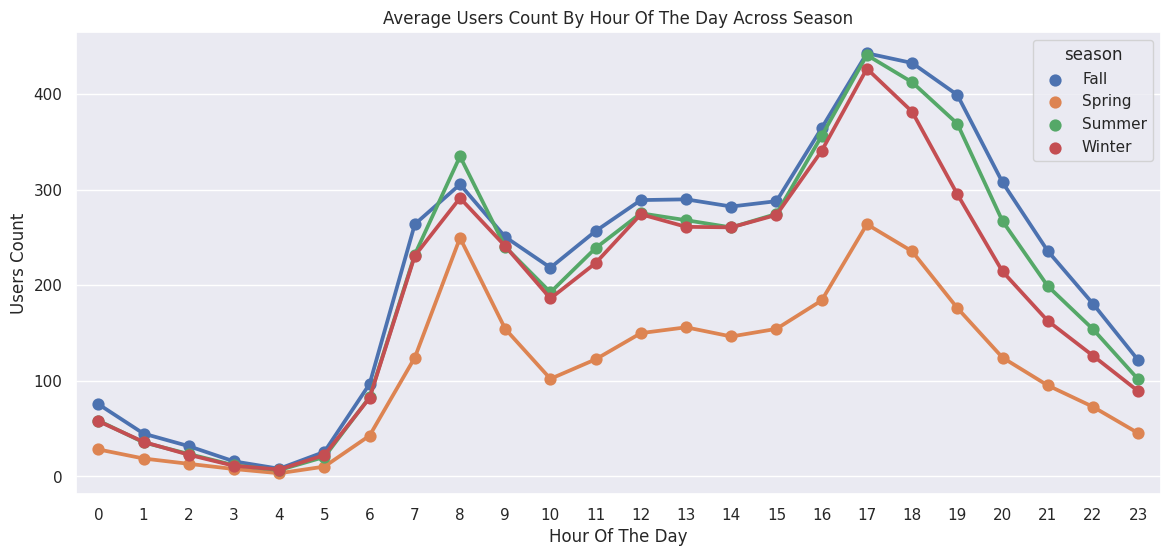

In [ ]:
fig,(ax1)= plt.subplots(nrows=1)
fig.set_size_inches(14,6)
sortOrder = ["January","February","March","April","May","June","July","August","September","October","November","December"]
hueOrder = ["Sunday","Monday","Tuesday","Wednesday","Thursday","Friday","Saturday"]

hourAggregated = pd.DataFrame(df.groupby(["hour","season"],sort=True)["count"].mean()).reset_index()
sb.pointplot(x=hourAggregated["hour"], y=hourAggregated["count"],hue=hourAggregated["season"], data=hourAggregated, join=True,ax=ax1)
ax1.set(xlabel='Hour Of The Day', ylabel='Users Count',title="Average Users Count By Hour Of The Day Across Season",label='big')


This shows us that count is significantly lower in spring, and in each day there is a spike in bike rentals at 0800 and 1700 hours.

E. Nomalize Target Variable 'Count' (log function)

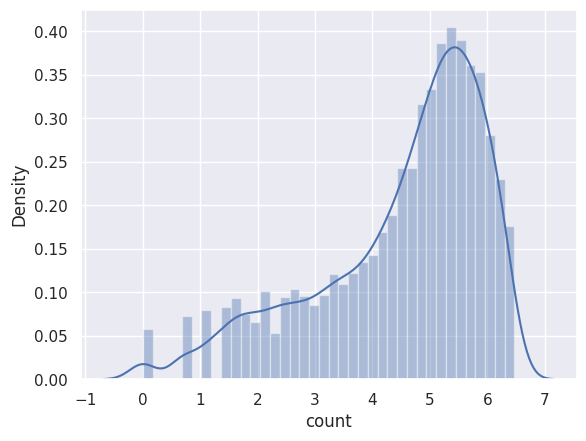

In [ ]:
df['count']=df['count'].apply(lambda x:np.log(x))
sb.distplot(df['count'])
plt.show()


Our target variable as previously seen is highly skewed, before moving on to model fitting we will try to transform this data using either log, square-root or box-cox transformation. After trying out all three, log square gives the best result.

4. Model fitting

One Hot encode season variable

In [ ]:
# Select columns from original dataframe
#selected_cols = ['hour', 'month', 'temp', 'season_Fall', 'season_Spring', 'season_Summer', 'season_Winter', 'count']
selected_cols = ['hour', 'month', 'temp', 'season', 'count']


# Create new dataframe with selected columns
df_selected = df[selected_cols].copy()

# One-hot encode the 'season' variable
season_dummies = pd.get_dummies(df_selected['season'], prefix='season')
df_selected = pd.concat([df_selected, season_dummies], axis=1)

# Drop the original 'season' variable
df_selected.drop('season', axis=1, inplace=True)

df_selected.head()

,hour,month,temp,count,season_Fall,season_Spring,season_Summer,season_Winter
1,0,1,9.84,2.772589,0,1,0,0
2,1,1,9.02,3.688879,0,1,0,0
3,2,1,9.02,3.465736,0,1,0,0
4,3,1,9.84,2.564949,0,1,0,0
5,4,1,9.84,0.000000,0,1,0,0


In [ ]:
# Split data into train and test sets
x_train, x_test, y_train, y_test = train_test_split(df_selected.drop('count', axis=1), df_selected['count'], test_size=0.20, random_state=1)

# Define models and their names
models = [RandomForestRegressor(), AdaBoostRegressor(), BaggingRegressor(), SVR(), KNeighborsRegressor()]
model_names = ['RandomForestRegressor', 'AdaBoostRegressor', 'BaggingRegressor', 'SVR', 'KNeighborsRegressor']

# Initialize lists to store performance metrics
rmsle = []
mae = []
rmse = []
r2 = []

# Loop over all models and calculate performance metrics
for model in range(len(models)):
    clf = models[model]
    clf.fit(x_train, y_train)
    test_pred = clf.predict(x_test)
    rmsle.append(np.sqrt(mean_squared_log_error(test_pred, y_test)))
    mae.append(mean_absolute_error(test_pred, y_test))
    rmse.append(np.sqrt(((test_pred - y_test) ** 2).mean()))
    r2.append(r2_score(y_test, test_pred))

# Combine performance metrics into a dictionary
d = {'Modelling Algo': model_names, 'RMSLE': rmsle, 'MAE': mae, 'RMSE': rmse, 'R2': r2}

# Print the results
print("{:<25} {:<20} {:<20} {:<20} {:<20}".format('Model', 'RMSLE', 'MAE', 'RMSE', 'R2'))
for i in range(len(models)):
    print("{:<25} {:<20.4f} {:<20.4f} {:<20.4f} {:<20.4f}".format(d['Modelling Algo'][i], d['RMSLE'][i], d['MAE'][i], d['RMSE'][i], d['R2'][i]))

Model                     RMSLE                MAE                  RMSE                 R2                  
RandomForestRegressor     0.2105               0.5824               0.7987               0.7055              
AdaBoostRegressor         0.2046               0.6303               0.7995               0.7049              
BaggingRegressor          0.2129               0.5931               0.8114               0.6960              
SVR                       0.2519               0.6898               0.9325               0.5985              
KNeighborsRegressor       0.2008               0.5618               0.7632               0.7311              


RMSLE (Root Mean Squared Log Error) - measures the ratio between the actual and predicted values. It is calculated as the square root of the mean of the squared logarithmic differences between the predicted and actual values.

MAE (Mean Absolute Error) - measures the average absolute difference between the predicted and actual values. It is calculated as the mean of the absolute differences between the predicted and actual values.

RMSE (Root Mean Squared Error) - measures the square root of the average of the squared differences between the predicted and actual values. It is a commonly used metric in regression problems.

R2 (R-squared) - measures the proportion of the variance in the dependent variable that is predictable from the independent variables. It is a statistical measure that ranges from 0 to 1, with 1 indicating a perfect fit of the model to the data.

Based on the performance metrics displayed in the table, the KNeighborsRegressor model has the lowest RMSLE, MAE, and RMSE scores and the highest R2 score. Therefore, the KNeighborsRegressor model is the best performing model for this particular problem.

In [ ]:
#for random forest regresion.
#no_of_test=[500]
#params_dict={'n_estimators':no_of_test,'n_jobs':[-1],'max_features':["auto",'sqrt','log2']}
#clf_rf=GridSearchCV(estimator=RandomForestRegressor(),param_grid=params_dict,scoring='neg_mean_squared_log_error')
#clf_rf.fit(x_train,y_train)
#pred=clf_rf.predict(x_test)
#print((np.sqrt(mean_squared_log_error(pred,y_test))))

In [ ]:
#clf_rf.best_params_

In [ ]:
# for KNN
n_neighbors=[]
for i in range (0,50,5):
    if(i!=0):
        n_neighbors.append(i)
params_dict={'n_neighbors':n_neighbors,'n_jobs':[-1]}
clf_knn=GridSearchCV(estimator=KNeighborsRegressor(),param_grid=params_dict,scoring='neg_mean_squared_log_error')
clf_knn.fit(x_train,y_train)
pred=clf_knn.predict(x_test)
print((np.sqrt(mean_squared_log_error(pred,y_test))))

0.19008166343991725


In [ ]:
clf_knn.best_params_

{'n_jobs': -1, 'n_neighbors': 15}

In [ ]:
#test_df = pd.read_csv('/content/test.csv', header = None)
#pred=clf_knn.predict(test_df.drop('datetime',axis=1))
#d={'datetime':test_df['datetime'],'count':pred}
#ans=pd.DataFrame(d)
#ans.to_csv('answer.csv',index=False)